# **Imports:**

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from numpy.random import seed
import tensorflow as tf
from PIL import Image
import pandas as pd
import os
tf.random.set_seed(23)
seed(7)

### **Loading Images:**
In this section, we load the directories of the images from the different classes.

In [2]:
# loading data
base_dir = 'fire_dataset'


# loading the directories containing train and testing tests
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
valid_dir = os.path.join(base_dir, 'valid')

# loading the training set for both fire_images and non_fire_images
train_fire_images_dir = os.path.join(train_dir, 'fire_images')
train_non_fire_images_dir = os.path.join(train_dir, 'non_fire_images')


# loading the testing set for both fire_images and non_fire_images
test_fire_images_dir = os.path.join(test_dir, 'fire_images')
test_non_fire_images_dir = os.path.join(test_dir, 'non_fire_images')


# loading the validation set for both fire_images and non_fire_images
valid_fire_images_dir = os.path.join(valid_dir, 'fire_images')
valid_non_fire_images_dir = os.path.join(valid_dir, 'non_fire_images')



# **Creating data generators:**
In this section, we generate the different ImageDataGenerators that will assist in loading the images in batches during the training of our model or testing our model.

In [3]:

#creating ImageDataGenerators that will normalize the pixels of both training and testing sets 
train_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

# flow training images in batches of 50 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=50, class_mode='binary', target_size=(150,150))

# flow testing images in batches of 10 using train_datagen generator
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=10, class_mode='binary', target_size=(150,150))

# flow testing images in batches of 10 using train_datagen generator
valid_generator = valid_datagen.flow_from_directory(valid_dir, batch_size=10, class_mode='binary', target_size=(150,150))

Found 650 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 149 images belonging to 2 classes.


Our dataset contains 999 images. The images are separated into classes, namely non-fire-images and fire images. 650 images from these two classes are reserved for training purposes and the rest for testing and validation purposes. It is clear that this dataset is small for training a CNN, so in the next section, we perform image augmentation so that on each epoch when we train and test our models a new variant of an image will be given to the network. We hope this will help to avoid the overfitting of the model.

# **Image Augmentation:**


In [4]:
# augmenting the training dataset
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range= 45,
        width_shift_range=0.1,
        height_shift_range=0.25, 
        zoom_range=0.1,
        horizontal_flip=True, 
        vertical_flip = True,
        brightness_range=[0.25,1.25],
        fill_mode ='nearest'
) 
#augmenting the testing dataset
test_datagen = ImageDataGenerator(rotation_range= 15,
        width_shift_range=0.1,
        height_shift_range=0.15, 
        zoom_range=0.32,
        horizontal_flip=True, 
        vertical_flip = True,
        brightness_range=[0.25,1.25],
        rescale = 1./255,
        fill_mode = 'nearest'
                                  
)



# **Initial model:** 
The network takes in an image with 150 x 150 pixels with three channels. This model consists of two layers of convolutional neural networks. The first layer of convolutional neural networks consists of five filters of size 3x3, and a relu activation function is applied to the activation maps generated by these networks. We hope this activation function will help increase the non-linearity of these activation maps. This layer is directly followed by a max-pooling layer with a window of size 2x2. This pooling layer's outputs are fed to the next layer of convolutional neural networks. This second layer of convolutional neural networks consists of 10 filters of size 3 x 3, and a relu activation function is applied to the activation maps generated by these convolutional neural networks. The outputs of this layer are then given to a max-pooling layer with a window size of 2 x 2. We want this pooling layer to reduce the dimensions of the activation maps and ultimately reduce the number of parameters in the general network. The outputs of this layer are then flattened out and fed directly to a set of fully connected neural networks whether the final classification of the image will take place.

All the other models, that we will create to explore in attempt to achieve higher performance,  will be a variation of this model.

In [5]:
# Constructing the initial model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(5, (3,3), activation = 'relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(10, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])


# initializing optimizerz to learn the model
lr = 0.0001
opt = tf.keras.optimizers.Adam(learning_rate = lr)
loss_func = 'binary_crossentropy'
metrics_list = ['acc']

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 5)       140       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 5)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 10)        460       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12960)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                129610    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In the next cell we first define a function to compile and train a network. We the proceed an define a function to plot the losses and accuracies of the model.

In [6]:
# compile and train the model function
def train_model(opt, loss_func, metrics, model, file_name):
    # compiling the model
    model.compile(optimizer = opt, loss = loss_func, metrics = metrics_list)
    # save best validation accuracy
    save_best_acc = ModelCheckpoint(file_name, monitor ='val_acc', mode ='max', verbose = 1, save_best_only =True)
    
    # training the model
    history = model.fit(train_generator,
                    validation_data = test_generator,
                    steps_per_epoch = 13,
                    epochs = 20,
                    validation_steps = 20,
                    verbose = 1,
                    shuffle = False,
                    workers = 13,
                    callbacks = [save_best_acc]
    )
    return history
# function to plot losses and accuracies
def loss_acc_func(model_output, model_name):
    training_loss = model_output.history['loss']
    validation_loss = model_output.history['val_loss']
    training_acc = model_output.history['acc']
    validation_acc = model_output.history['val_acc']
    epochs_list = list(range(1, 21))
    plt.plot(epochs_list, training_loss, label = 'training_loss', color= 'r')
    plt.plot(epochs_list, validation_loss,label ='validation_loss', color = 'b')
    plt.plot(epochs_list, training_acc, label = 'training_acc', color ='y')
    plt.plot(epochs_list, validation_acc,label ='validation_acc', color ='g')
    plt.title("loss & accuracy functions:")
    plt.xlabel("epochs")
    plt.ylabel("loss/acc")
    plt.legend()
    plt.savefig(model_name)
    plt.show()

In [7]:
# train the initial model
file_name = "best_val_acc_initial_model.h5"
model_hist = train_model(opt, loss_func, metrics_list, model, file_name)

Epoch 1/20
13/13 [==============================] - 14s 763ms/step - loss: 0.5955 - acc: 0.7000 - val_loss: 0.5573 - val_acc: 0.7800

Epoch 00001: val_acc improved from -inf to 0.78000, saving model to best_val_acc_initial_model.h5
Epoch 2/20
13/13 [==============================] - 12s 690ms/step - loss: 0.5429 - acc: 0.7169 - val_loss: 0.4632 - val_acc: 0.7650

Epoch 00002: val_acc did not improve from 0.78000
Epoch 3/20
13/13 [==============================] - 13s 715ms/step - loss: 0.4800 - acc: 0.7308 - val_loss: 0.4350 - val_acc: 0.7600

Epoch 00003: val_acc did not improve from 0.78000
Epoch 4/20
13/13 [==============================] - 14s 802ms/step - loss: 0.4359 - acc: 0.7677 - val_loss: 0.4022 - val_acc: 0.8100

Epoch 00004: val_acc improved from 0.78000 to 0.81000, saving model to best_val_acc_initial_model.h5
Epoch 5/20
13/13 [==============================] - 14s 774ms/step - loss: 0.4092 - acc: 0.8123 - val_loss: 0.3804 - val_acc: 0.8200

Epoch 00005: val_acc improved f

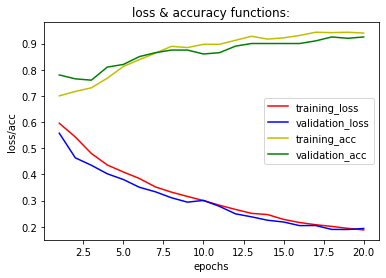

In [8]:
### plotting loss and accuracy functions for initial model
loss_acc_func(model_hist, "initial model")

In [9]:
# displaying the learned filers
def display_filters(model):
    for i in range(len(model.layers)):
        layer = model.layers[i]
        # checking for convolutional layers
        if 'conv' not in layer.name:
            continue
        filters, bias = layer.get_weights()
        print("Convolutional layer description: ", layer.name, ":", filters.shape)
        # getting min and max vals in the filters 
        f_min, f_max = filters.min(), filters.max()
        # normalizing the filters
        filters = (filters - f_min) / (f_max - f_min)
        print("Number of filters in the convolutional layer :", filters.shape[3])
        filter_cnt=1

        print("Learned features in this layer: (R G B) channels")
        #plotting all the filters
        for i in range(filters.shape[3]):
            #get the filters
            filt=filters[:,:,:, i]
            #plotting each of the channel, color image RGB channels
            for j in range(filters.shape[0]):
                ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        plt.show()

Convolutional layer description:  conv2d : (3, 3, 3, 5)
Number of filters in the convolutional layer : 5
Learned features in this layer: (R G B) channels


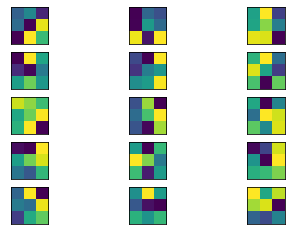

Convolutional layer description:  conv2d_1 : (3, 3, 5, 10)
Number of filters in the convolutional layer : 10
Learned features in this layer: (R G B) channels


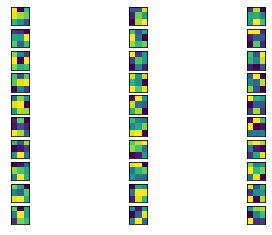

In [10]:
display_filters(model)

# **Experiment one: Investigating how an increase in the number of filters in each layer affects the performance of the network**

In this section, we investigate how increasing the number of filters in each convolutional neural layer and the number of neutrons in the hidden dense layer of our initial model will influence the performance of the network. 

## **Model two:**

In [11]:
# Constructing the two model
model_two = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(10, (3,3), activation = 'relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(20, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(20, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# model two summary
model_two.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 10)      280       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 10)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 20)        1820      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 20)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25920)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                518420    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [12]:
# train the  model two
file_name = "best_val_acc_model_two.h5"
model_hist = train_model(opt, loss_func, metrics_list, model_two, file_name)

Epoch 1/20
13/13 [==============================] - 17s 1s/step - loss: 0.5301 - acc: 0.7400 - val_loss: 0.3389 - val_acc: 0.9100

Epoch 00001: val_acc improved from -inf to 0.91000, saving model to best_val_acc_model_two.h5
Epoch 2/20
13/13 [==============================] - 16s 1s/step - loss: 0.2596 - acc: 0.9108 - val_loss: 0.1971 - val_acc: 0.9400

Epoch 00002: val_acc improved from 0.91000 to 0.94000, saving model to best_val_acc_model_two.h5
Epoch 3/20
13/13 [==============================] - 17s 1s/step - loss: 0.1645 - acc: 0.9462 - val_loss: 0.1591 - val_acc: 0.9200

Epoch 00003: val_acc did not improve from 0.94000
Epoch 4/20
13/13 [==============================] - 17s 978ms/step - loss: 0.1468 - acc: 0.9477 - val_loss: 0.1414 - val_acc: 0.9350

Epoch 00004: val_acc did not improve from 0.94000
Epoch 5/20
13/13 [==============================] - 15s 876ms/step - loss: 0.1284 - acc: 0.9446 - val_loss: 0.1270 - val_acc: 0.9650

Epoch 00005: val_acc improved from 0.94000 to 0.

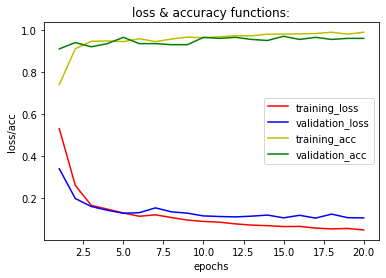

In [13]:
### plotting loss and accuracy functions for model two
loss_acc_func(model_hist, "model two")

Convolutional layer description:  conv2d_2 : (3, 3, 3, 10)
Number of filters in the convolutional layer : 10
Learned features in this layer: (R G B) channels


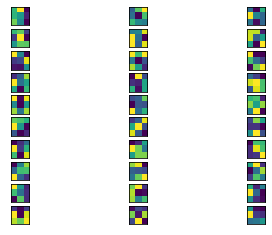

Convolutional layer description:  conv2d_3 : (3, 3, 10, 20)
Number of filters in the convolutional layer : 20
Learned features in this layer: (R G B) channels


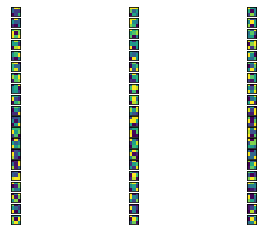

In [14]:
# displaying filters learned by model two
display_filters(model_two)

## **Model three:**

In [15]:
# Constructing  model three
model_three = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(20, (3,3), activation = 'relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(40, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(40, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# model two summary
model_three.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 20)      560       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 20)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 40)        7240      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 40)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 51840)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 40)                2073640   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [16]:
# train the  model three
file_name = "best_val_acc_model_three.h5"
model_hist = train_model(opt, loss_func, metrics_list, model_three, file_name)

Epoch 1/20
13/13 [==============================] - 20s 1s/step - loss: 0.5681 - acc: 0.7877 - val_loss: 0.3172 - val_acc: 0.9250

Epoch 00001: val_acc improved from -inf to 0.92500, saving model to best_val_acc_model_three.h5
Epoch 2/20
13/13 [==============================] - 20s 1s/step - loss: 0.2559 - acc: 0.9000 - val_loss: 0.1617 - val_acc: 0.9400

Epoch 00002: val_acc improved from 0.92500 to 0.94000, saving model to best_val_acc_model_three.h5
Epoch 3/20
13/13 [==============================] - 20s 1s/step - loss: 0.1566 - acc: 0.9385 - val_loss: 0.1220 - val_acc: 0.9450

Epoch 00003: val_acc improved from 0.94000 to 0.94500, saving model to best_val_acc_model_three.h5
Epoch 4/20
13/13 [==============================] - 20s 1s/step - loss: 0.1286 - acc: 0.9538 - val_loss: 0.1177 - val_acc: 0.9500

Epoch 00004: val_acc improved from 0.94500 to 0.95000, saving model to best_val_acc_model_three.h5
Epoch 5/20
13/13 [==============================] - 22s 1s/step - loss: 0.1070 - ac

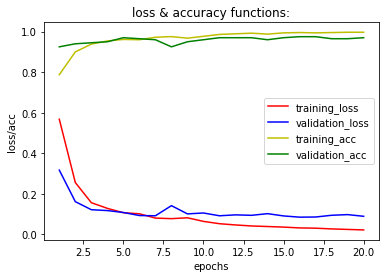

In [17]:
## plotting loss and accuracy functions for model three
loss_acc_func(model_hist, "model_three")

Convolutional layer description:  conv2d_4 : (3, 3, 3, 20)
Number of filters in the convolutional layer : 20
Learned features in this layer: (R G B) channels


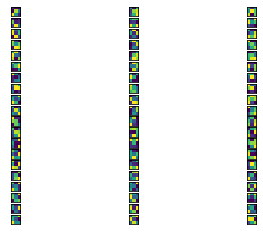

Convolutional layer description:  conv2d_5 : (3, 3, 20, 40)
Number of filters in the convolutional layer : 40
Learned features in this layer: (R G B) channels


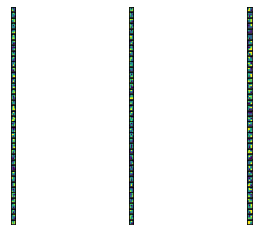

In [18]:
# displaying filters learned by model three
display_filters(model_three)

# **Experiment two: Investigating how the depth of the network influences performance:**
In this section, we investigate the influence of the depth of our network on the performance of the network.
We will use several models to investigate this. We will increase the number of convolutional layers in our initial model.

## **Model four:**

In [19]:
# Constructing the fourth model
model_four = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(5, (3,3), activation = 'relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(10, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(20, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(20, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
# model four summary
model_four.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 5)       140       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 5)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 10)        460       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 10)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 20)        1820      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 20)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 5780)             

In [20]:
# train the  model four
file_name = "best_val_acc_model_four.h5"
model_hist = train_model(opt, loss_func, metrics_list, model_four, file_name)

Epoch 1/20
13/13 [==============================] - 15s 887ms/step - loss: 0.5542 - acc: 0.7431 - val_loss: 0.4195 - val_acc: 0.7950

Epoch 00001: val_acc improved from -inf to 0.79500, saving model to best_val_acc_model_four.h5
Epoch 2/20
13/13 [==============================] - 14s 822ms/step - loss: 0.3572 - acc: 0.8400 - val_loss: 0.3161 - val_acc: 0.8750

Epoch 00002: val_acc improved from 0.79500 to 0.87500, saving model to best_val_acc_model_four.h5
Epoch 3/20
13/13 [==============================] - 15s 876ms/step - loss: 0.2600 - acc: 0.9077 - val_loss: 0.2084 - val_acc: 0.9100

Epoch 00003: val_acc improved from 0.87500 to 0.91000, saving model to best_val_acc_model_four.h5
Epoch 4/20
13/13 [==============================] - 13s 839ms/step - loss: 0.1979 - acc: 0.9200 - val_loss: 0.1768 - val_acc: 0.9250

Epoch 00004: val_acc improved from 0.91000 to 0.92500, saving model to best_val_acc_model_four.h5
Epoch 5/20
13/13 [==============================] - 14s 813ms/step - loss: 

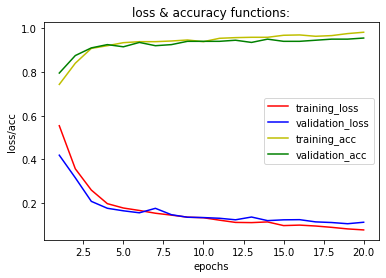

In [21]:
## plotting loss and accuracy functions for model four
loss_acc_func(model_hist, "model four")

Convolutional layer description:  conv2d_6 : (3, 3, 3, 5)
Number of filters in the convolutional layer : 5
Learned features in this layer: (R G B) channels


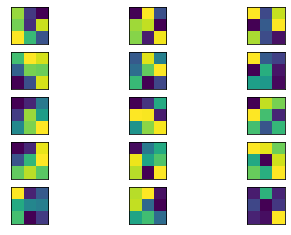

Convolutional layer description:  conv2d_7 : (3, 3, 5, 10)
Number of filters in the convolutional layer : 10
Learned features in this layer: (R G B) channels


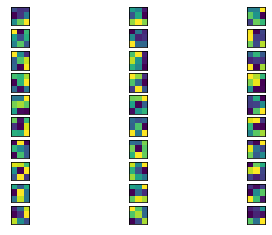

Convolutional layer description:  conv2d_8 : (3, 3, 10, 20)
Number of filters in the convolutional layer : 20
Learned features in this layer: (R G B) channels


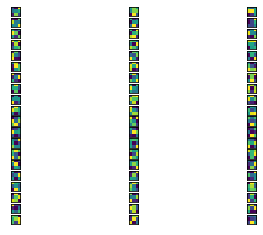

In [22]:
# displaying filters learned by model four
display_filters(model_four)

## **Model five:**

In [23]:
# Constructing the five model
model_five = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(5, (3,3), activation = 'relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(10, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(20, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(40, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(40, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
# model four summary
model_five.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 5)       140       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 5)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 10)        460       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 10)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 20)        1820      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 20)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 40)       

In [24]:
# train the  model five
file_name = "best_val_acc_model_five.h5"
model_hist = train_model(opt, loss_func, metrics_list, model_five, file_name)

Epoch 1/20
13/13 [==============================] - 15s 823ms/step - loss: 0.6604 - acc: 0.6538 - val_loss: 0.5697 - val_acc: 0.7550

Epoch 00001: val_acc improved from -inf to 0.75500, saving model to best_val_acc_model_five.h5
Epoch 2/20
13/13 [==============================] - 14s 799ms/step - loss: 0.5060 - acc: 0.7708 - val_loss: 0.3319 - val_acc: 0.9150

Epoch 00002: val_acc improved from 0.75500 to 0.91500, saving model to best_val_acc_model_five.h5
Epoch 3/20
13/13 [==============================] - 14s 805ms/step - loss: 0.3184 - acc: 0.8708 - val_loss: 0.2929 - val_acc: 0.8750

Epoch 00003: val_acc did not improve from 0.91500
Epoch 4/20
13/13 [==============================] - 15s 814ms/step - loss: 0.2913 - acc: 0.8862 - val_loss: 0.2512 - val_acc: 0.8950

Epoch 00004: val_acc did not improve from 0.91500
Epoch 5/20
13/13 [==============================] - 14s 814ms/step - loss: 0.2580 - acc: 0.8954 - val_loss: 0.1912 - val_acc: 0.9350

Epoch 00005: val_acc improved from 0.

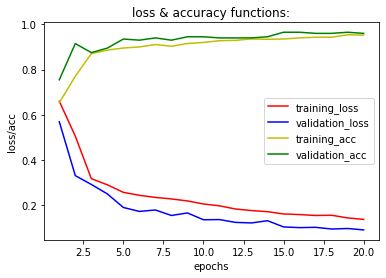

In [25]:
## plotting loss and accuracy functions for model five
loss_acc_func(model_hist,"model five")

Convolutional layer description:  conv2d_9 : (3, 3, 3, 5)
Number of filters in the convolutional layer : 5
Learned features in this layer: (R G B) channels


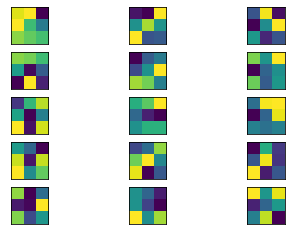

Convolutional layer description:  conv2d_10 : (3, 3, 5, 10)
Number of filters in the convolutional layer : 10
Learned features in this layer: (R G B) channels


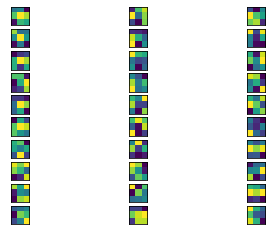

Convolutional layer description:  conv2d_11 : (3, 3, 10, 20)
Number of filters in the convolutional layer : 20
Learned features in this layer: (R G B) channels


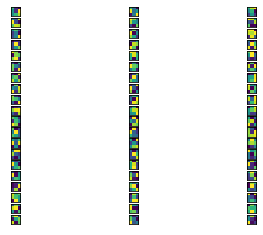

Convolutional layer description:  conv2d_12 : (3, 3, 20, 40)
Number of filters in the convolutional layer : 40
Learned features in this layer: (R G B) channels


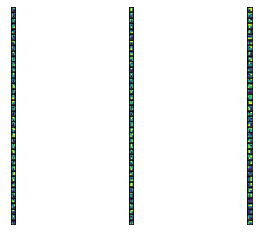

In [26]:
# displaying filters learned by model five
display_filters(model_five)
model_five.save('model_five.h5')

# **Experiment three: Investigating how applying the different activation functions on the activation map influence the performance of the network:**

In this section, we are going to apply different activation functions on the activation maps produced by our convolutional layers of our initial model.

## **Model six:**

In [27]:
# Constructing the model six
model_six = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(5, (3,3), activation = 'sigmoid', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(10, (3,3), activation = 'sigmoid'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
# model six summary
model_six.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 5)       140       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 5)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 10)        460       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 10)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 12960)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                129610    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [28]:
# train the  model six
file_name = "best_val_acc_model_six.h5"
model_hist = train_model(opt, loss_func, metrics_list, model_six, file_name)

Epoch 1/20
13/13 [==============================] - 14s 799ms/step - loss: 0.6280 - acc: 0.6785 - val_loss: 0.5578 - val_acc: 0.7550

Epoch 00001: val_acc improved from -inf to 0.75500, saving model to best_val_acc_model_six.h5
Epoch 2/20
13/13 [==============================] - 13s 797ms/step - loss: 0.6180 - acc: 0.7000 - val_loss: 0.5579 - val_acc: 0.7550

Epoch 00002: val_acc did not improve from 0.75500
Epoch 3/20
13/13 [==============================] - 13s 811ms/step - loss: 0.6138 - acc: 0.7000 - val_loss: 0.5722 - val_acc: 0.7550

Epoch 00003: val_acc did not improve from 0.75500
Epoch 4/20
13/13 [==============================] - 13s 749ms/step - loss: 0.6199 - acc: 0.7000 - val_loss: 0.5572 - val_acc: 0.7550

Epoch 00004: val_acc did not improve from 0.75500
Epoch 5/20
13/13 [==============================] - 13s 784ms/step - loss: 0.6236 - acc: 0.7000 - val_loss: 0.5641 - val_acc: 0.7550

Epoch 00005: val_acc did not improve from 0.75500
Epoch 6/20
13/13 [==================

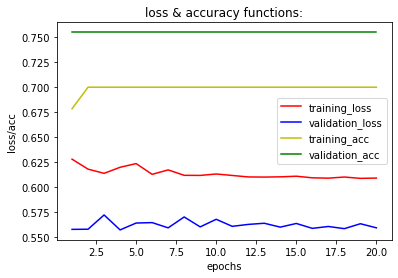

In [29]:
## plotting loss and accuracy functions for model six
loss_acc_func(model_hist, "model six")

Convolutional layer description:  conv2d_13 : (3, 3, 3, 5)
Number of filters in the convolutional layer : 5
Learned features in this layer: (R G B) channels


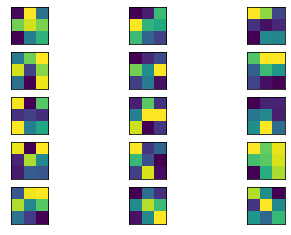

Convolutional layer description:  conv2d_14 : (3, 3, 5, 10)
Number of filters in the convolutional layer : 10
Learned features in this layer: (R G B) channels


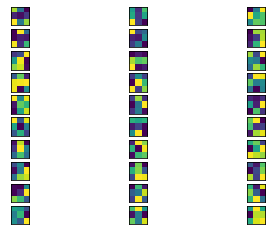

In [30]:
# displaying filters learned by model six
display_filters(model_six)

## **Model seven:**

In [31]:
# Constructing the model seven
model_seven = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(5, (3,3), activation = 'tanh', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(10, (3,3), activation = 'tanh'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
# model six summary
model_seven.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 148, 148, 5)       140       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 74, 74, 5)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 72, 72, 10)        460       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 36, 36, 10)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 12960)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                129610    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [32]:
# train the  model seven
file_name = "best_val_acc_model_seven.h5"
model_hist = train_model(opt, loss_func, metrics_list, model_seven, file_name)

Epoch 1/20
13/13 [==============================] - 13s 854ms/step - loss: 0.3688 - acc: 0.8077 - val_loss: 0.1727 - val_acc: 0.9300

Epoch 00001: val_acc improved from -inf to 0.93000, saving model to best_val_acc_model_seven.h5
Epoch 2/20
13/13 [==============================] - 14s 807ms/step - loss: 0.2291 - acc: 0.9015 - val_loss: 0.1454 - val_acc: 0.9500

Epoch 00002: val_acc improved from 0.93000 to 0.95000, saving model to best_val_acc_model_seven.h5
Epoch 3/20
13/13 [==============================] - 14s 794ms/step - loss: 0.1811 - acc: 0.9215 - val_loss: 0.1120 - val_acc: 0.9750

Epoch 00003: val_acc improved from 0.95000 to 0.97500, saving model to best_val_acc_model_seven.h5
Epoch 4/20
13/13 [==============================] - 13s 810ms/step - loss: 0.1557 - acc: 0.9354 - val_loss: 0.1159 - val_acc: 0.9400

Epoch 00004: val_acc did not improve from 0.97500
Epoch 5/20
13/13 [==============================] - 14s 757ms/step - loss: 0.1368 - acc: 0.9446 - val_loss: 0.1212 - val

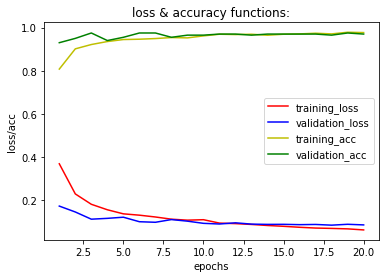

In [33]:
## plotting loss and accuracy functions for model seven
loss_acc_func(model_hist, "model seven")

Convolutional layer description:  conv2d_15 : (3, 3, 3, 5)
Number of filters in the convolutional layer : 5
Learned features in this layer: (R G B) channels


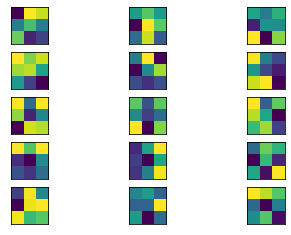

Convolutional layer description:  conv2d_16 : (3, 3, 5, 10)
Number of filters in the convolutional layer : 10
Learned features in this layer: (R G B) channels


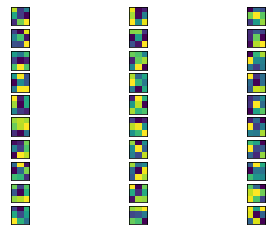

In [34]:
# displaying filters learned by model seven
display_filters(model_seven)

# **Experiment four: Investigating how the window size of the pooling layers influences the performance of the network:**
In this part, we investigate how the increase in the window size  of the pooling layers in our initial model will influence the network performance. 

## **Model eight:**

In [ ]:
# Constructing the model eight
model_eight = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(5, (3,3), activation = 'relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D((3,3)),
    tf.keras.layers.Conv2D(10, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
# model summary
model_eight.summary()

In [36]:
# train the  model eight
file_name = "best_val_acc_model_eight.h5"
model_hist = train_model(opt, loss_func, metrics_list,model_eight, file_name)

Epoch 1/20
13/13 [==============================] - 14s 765ms/step - loss: 0.6452 - acc: 0.6738 - val_loss: 0.5576 - val_acc: 0.7550

Epoch 00001: val_acc improved from -inf to 0.75500, saving model to best_val_acc_model_eight.h5
Epoch 2/20
13/13 [==============================] - 13s 744ms/step - loss: 0.5838 - acc: 0.7015 - val_loss: 0.4985 - val_acc: 0.7550

Epoch 00002: val_acc did not improve from 0.75500
Epoch 3/20
13/13 [==============================] - 13s 761ms/step - loss: 0.5079 - acc: 0.7123 - val_loss: 0.4158 - val_acc: 0.8300

Epoch 00003: val_acc improved from 0.75500 to 0.83000, saving model to best_val_acc_model_eight.h5
Epoch 4/20
13/13 [==============================] - 13s 762ms/step - loss: 0.4183 - acc: 0.8369 - val_loss: 0.3329 - val_acc: 0.9250

Epoch 00004: val_acc improved from 0.83000 to 0.92500, saving model to best_val_acc_model_eight.h5
Epoch 5/20
13/13 [==============================] - 12s 717ms/step - loss: 0.3466 - acc: 0.8600 - val_loss: 0.2847 - val

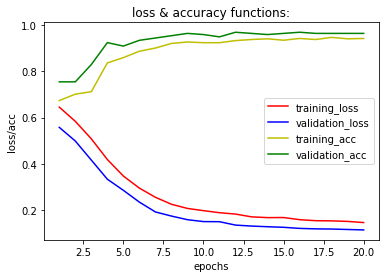

In [37]:
## plotting loss and accuracy functions for model eight
loss_acc_func(model_hist, "model eight")

Convolutional layer description:  conv2d_17 : (3, 3, 3, 5)
Number of filters in the convolutional layer : 5
Learned features in this layer: (R G B) channels


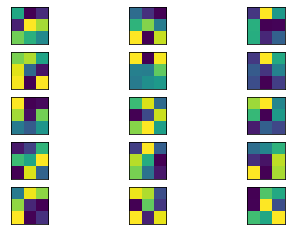

Convolutional layer description:  conv2d_18 : (3, 3, 5, 10)
Number of filters in the convolutional layer : 10
Learned features in this layer: (R G B) channels


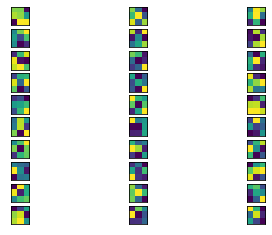

In [38]:
# displaying filters learned by model eight
display_filters(model_eight)
model_eight.save('model_eight.h5')

## **Model nine:**

In [39]:
# Constructing the model nine
model_nine = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(5, (3,3), activation = 'relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D((5,5)),
    tf.keras.layers.Conv2D(10, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(5,5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
# model nine summary
model_nine.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 148, 148, 5)       140       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 29, 29, 5)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 27, 27, 10)        460       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 5, 5, 10)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 250)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                2510      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

In [40]:
# train the  model nine
file_name = "best_val_acc_mode_nine.h5"
model_hist = train_model(opt, loss_func, metrics_list, model_nine, file_name)

Epoch 1/20
13/13 [==============================] - 12s 679ms/step - loss: 0.7490 - acc: 0.4477 - val_loss: 0.6009 - val_acc: 0.7500

Epoch 00001: val_acc improved from -inf to 0.75000, saving model to best_val_acc_mode_nine.h5
Epoch 2/20
13/13 [==============================] - 12s 651ms/step - loss: 0.5386 - acc: 0.7092 - val_loss: 0.4544 - val_acc: 0.7600

Epoch 00002: val_acc improved from 0.75000 to 0.76000, saving model to best_val_acc_mode_nine.h5
Epoch 3/20
13/13 [==============================] - 11s 622ms/step - loss: 0.4420 - acc: 0.7492 - val_loss: 0.3656 - val_acc: 0.8700

Epoch 00003: val_acc improved from 0.76000 to 0.87000, saving model to best_val_acc_mode_nine.h5
Epoch 4/20
13/13 [==============================] - 12s 651ms/step - loss: 0.3496 - acc: 0.9031 - val_loss: 0.2764 - val_acc: 0.9650

Epoch 00004: val_acc improved from 0.87000 to 0.96500, saving model to best_val_acc_mode_nine.h5
Epoch 5/20
13/13 [==============================] - 12s 657ms/step - loss: 0.27

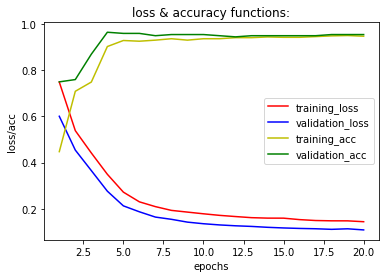

In [41]:
## plotting loss and accuracy functions for model nine
loss_acc_func(model_hist, "model_nine")

Convolutional layer description:  conv2d_19 : (3, 3, 3, 5)
Number of filters in the convolutional layer : 5
Learned features in this layer: (R G B) channels


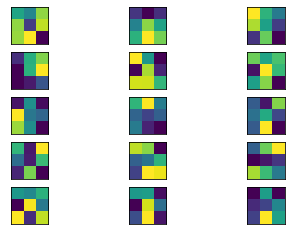

Convolutional layer description:  conv2d_20 : (3, 3, 5, 10)
Number of filters in the convolutional layer : 10
Learned features in this layer: (R G B) channels


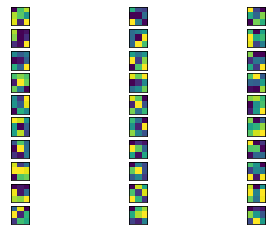

In [42]:
# displaying filters learned by model nine
display_filters(model_nine)

## **Model Ten:**

In [43]:

# Constructing the model ten
model_ten = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(5, (3,3), activation = 'relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D((7,7)),
    tf.keras.layers.Conv2D(10, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(7,7),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
# model nine summary
model_ten.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 148, 148, 5)       140       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 21, 21, 5)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 19, 19, 10)        460       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 2, 2, 10)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 40)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 10)                410       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                

In [44]:
# train the  model ten
file_name = "best_val_acc_model_ten.h5"
model_hist = train_model(opt, loss_func, metrics_list, model_ten, file_name)

Epoch 1/20
13/13 [==============================] - 13s 670ms/step - loss: 0.6745 - acc: 0.6938 - val_loss: 0.6483 - val_acc: 0.7550

Epoch 00001: val_acc improved from -inf to 0.75500, saving model to best_val_acc_model_ten.h5
Epoch 2/20
13/13 [==============================] - 12s 738ms/step - loss: 0.6402 - acc: 0.7000 - val_loss: 0.6052 - val_acc: 0.7550

Epoch 00002: val_acc did not improve from 0.75500
Epoch 3/20
13/13 [==============================] - 12s 683ms/step - loss: 0.6127 - acc: 0.7000 - val_loss: 0.5705 - val_acc: 0.7550

Epoch 00003: val_acc did not improve from 0.75500
Epoch 4/20
13/13 [==============================] - 12s 675ms/step - loss: 0.5897 - acc: 0.7000 - val_loss: 0.5412 - val_acc: 0.7550

Epoch 00004: val_acc did not improve from 0.75500
Epoch 5/20
13/13 [==============================] - 13s 625ms/step - loss: 0.5698 - acc: 0.7000 - val_loss: 0.5149 - val_acc: 0.7550

Epoch 00005: val_acc did not improve from 0.75500
Epoch 6/20
13/13 [==================

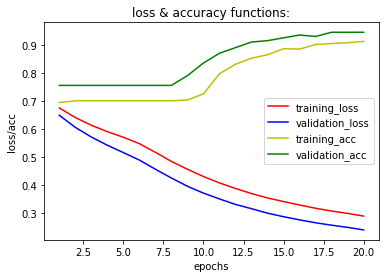

In [45]:
## plotting loss and accuracy functions for model nine
loss_acc_func(model_hist, "model_ten")

Convolutional layer description:  conv2d_21 : (3, 3, 3, 5)
Number of filters in the convolutional layer : 5
Learned features in this layer: (R G B) channels


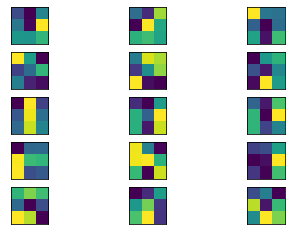

Convolutional layer description:  conv2d_22 : (3, 3, 5, 10)
Number of filters in the convolutional layer : 10
Learned features in this layer: (R G B) channels


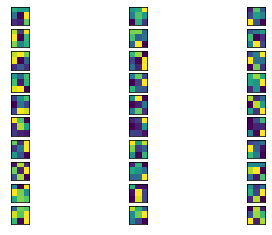

In [46]:
# displaying filters learned by model ten
display_filters(model_ten)

# **Experiment five: Investigating how the different optimizers influence the performance of network:**
In this section, we experiment with tensorflow optimizers and investigate how they influence the performance of our network.

## **Model eleven:**

In [47]:
#Constructing the  model eleven
model_eleven = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(5, (3,3), activation = 'relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(10, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# initializing optimizer
opt = tf.keras.optimizers.RMSprop(learning_rate = lr)

# model summary
model_eleven.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 148, 148, 5)       140       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 74, 74, 5)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 72, 72, 10)        460       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 36, 36, 10)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 12960)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)                129610    
_________________________________________________________________
dense_21 (Dense)             (None, 1)               

In [48]:
# train the  model eleven
file_name = "best_val_acc_model_eleven.h5"
model_hist = train_model(opt, loss_func, metrics_list, model_eleven, file_name)

Epoch 1/20
13/13 [==============================] - 15s 853ms/step - loss: 0.6155 - acc: 0.6892 - val_loss: 0.5339 - val_acc: 0.7550

Epoch 00001: val_acc improved from -inf to 0.75500, saving model to best_val_acc_model_eleven.h5
Epoch 2/20
13/13 [==============================] - 13s 788ms/step - loss: 0.5531 - acc: 0.7000 - val_loss: 0.5052 - val_acc: 0.7750

Epoch 00002: val_acc improved from 0.75500 to 0.77500, saving model to best_val_acc_model_eleven.h5
Epoch 3/20
13/13 [==============================] - 12s 761ms/step - loss: 0.5132 - acc: 0.7246 - val_loss: 0.4766 - val_acc: 0.7800

Epoch 00003: val_acc improved from 0.77500 to 0.78000, saving model to best_val_acc_model_eleven.h5
Epoch 4/20
13/13 [==============================] - 14s 892ms/step - loss: 0.4808 - acc: 0.7708 - val_loss: 0.4432 - val_acc: 0.7900

Epoch 00004: val_acc improved from 0.78000 to 0.79000, saving model to best_val_acc_model_eleven.h5
Epoch 5/20
13/13 [==============================] - 15s 832ms/step 

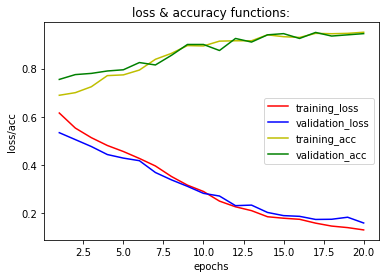

In [49]:
## plotting loss and accuracy functions for model nine
loss_acc_func(model_hist, "model_eleven")

Convolutional layer description:  conv2d_23 : (3, 3, 3, 5)
Number of filters in the convolutional layer : 5
Learned features in this layer: (R G B) channels


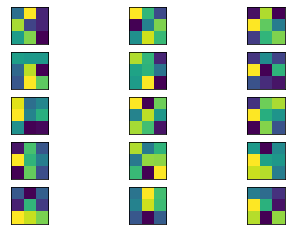

Convolutional layer description:  conv2d_24 : (3, 3, 5, 10)
Number of filters in the convolutional layer : 10
Learned features in this layer: (R G B) channels


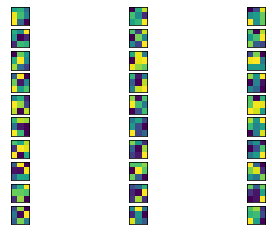

In [50]:
# displaying filters learned by model eleven
display_filters(model_eleven)
model_eleven.save('model_eleven.h5')

## **Model twelve:**

In [51]:
#Constructing the  model twelve
model_twelve = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(5, (3,3), activation = 'relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(10, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# initializing optimizer
opt = tf.keras.optimizers.SGD(learning_rate = lr)

# model summary
model_twelve.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 148, 148, 5)       140       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 74, 74, 5)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 72, 72, 10)        460       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 36, 36, 10)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 12960)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 10)                129610    
_________________________________________________________________
dense_23 (Dense)             (None, 1)               

In [52]:
# train the  model twelve
file_name = "best_val_acc_model_twelve.h5"
model_hist = train_model(opt, loss_func, metrics_list, model_twelve,file_name)

Epoch 1/20
13/13 [==============================] - 14s 784ms/step - loss: 0.8182 - acc: 0.3062 - val_loss: 0.8046 - val_acc: 0.2650

Epoch 00001: val_acc improved from -inf to 0.26500, saving model to best_val_acc_model_twelve.h5
Epoch 2/20
13/13 [==============================] - 13s 749ms/step - loss: 0.7603 - acc: 0.3169 - val_loss: 0.7490 - val_acc: 0.2850

Epoch 00002: val_acc improved from 0.26500 to 0.28500, saving model to best_val_acc_model_twelve.h5
Epoch 3/20
13/13 [==============================] - 13s 827ms/step - loss: 0.7209 - acc: 0.3754 - val_loss: 0.7110 - val_acc: 0.4450

Epoch 00003: val_acc improved from 0.28500 to 0.44500, saving model to best_val_acc_model_twelve.h5
Epoch 4/20
13/13 [==============================] - 13s 722ms/step - loss: 0.6958 - acc: 0.5031 - val_loss: 0.6867 - val_acc: 0.5450

Epoch 00004: val_acc improved from 0.44500 to 0.54500, saving model to best_val_acc_model_twelve.h5
Epoch 5/20
13/13 [==============================] - 14s 812ms/step 

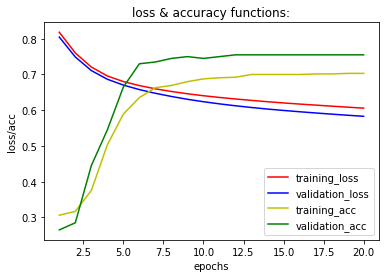

In [53]:
## plotting loss and accuracy functions for mode twelve
loss_acc_func(model_hist, "model_twelve")

Convolutional layer description:  conv2d_25 : (3, 3, 3, 5)
Number of filters in the convolutional layer : 5
Learned features in this layer: (R G B) channels


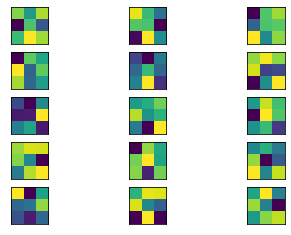

Convolutional layer description:  conv2d_26 : (3, 3, 5, 10)
Number of filters in the convolutional layer : 10
Learned features in this layer: (R G B) channels


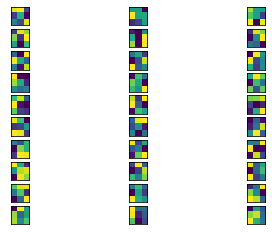

In [54]:
# displaying filters learned by model twelve
display_filters(model_twelve)
model_twelve.save('model_twelve.h5')

## **Model thirteen:**

In [55]:
#Constructing the  model thirteen
model_thirteen = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(5, (3,3), activation = 'relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(10, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# initializing optimizer
opt = tf.keras.optimizers.Adamax(learning_rate = lr)

# model summary
model_thirteen.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 148, 148, 5)       140       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 74, 74, 5)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 72, 72, 10)        460       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 36, 36, 10)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 12960)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 10)                129610    
_________________________________________________________________
dense_25 (Dense)             (None, 1)               

In [56]:
# train the  model thirteen
file_name = "best_val_acc_model_thirteen.h5"

model_hist = train_model(opt, loss_func, metrics_list, model_thirteen, file_name)

Epoch 1/20
13/13 [==============================] - 14s 886ms/step - loss: 0.6125 - acc: 0.6646 - val_loss: 0.5212 - val_acc: 0.7550

Epoch 00001: val_acc improved from -inf to 0.75500, saving model to best_val_acc_model_thirteen.h5
Epoch 2/20
13/13 [==============================] - 13s 786ms/step - loss: 0.5403 - acc: 0.7015 - val_loss: 0.4773 - val_acc: 0.7550

Epoch 00002: val_acc did not improve from 0.75500
Epoch 3/20
13/13 [==============================] - 13s 758ms/step - loss: 0.4991 - acc: 0.7200 - val_loss: 0.4410 - val_acc: 0.7750

Epoch 00003: val_acc improved from 0.75500 to 0.77500, saving model to best_val_acc_model_thirteen.h5
Epoch 4/20
13/13 [==============================] - 14s 865ms/step - loss: 0.4569 - acc: 0.7800 - val_loss: 0.4115 - val_acc: 0.8200

Epoch 00004: val_acc improved from 0.77500 to 0.82000, saving model to best_val_acc_model_thirteen.h5
Epoch 5/20
13/13 [==============================] - 13s 746ms/step - loss: 0.4243 - acc: 0.8231 - val_loss: 0.3

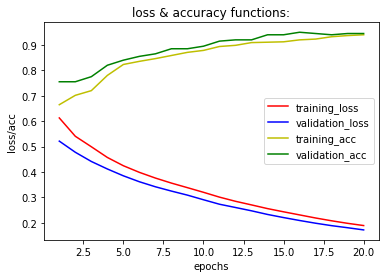

In [57]:
## plotting loss and accuracy functions for mode thirteen
loss_acc_func(model_hist, "model_thirteen")

Convolutional layer description:  conv2d_27 : (3, 3, 3, 5)
Number of filters in the convolutional layer : 5
Learned features in this layer: (R G B) channels


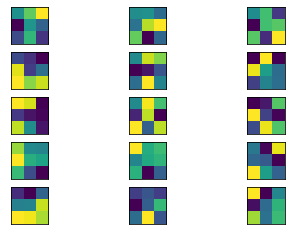

Convolutional layer description:  conv2d_28 : (3, 3, 5, 10)
Number of filters in the convolutional layer : 10
Learned features in this layer: (R G B) channels


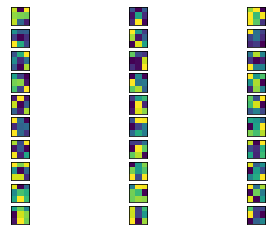

In [58]:
# displaying filters learned by model thirteen
display_filters(model_thirteen)

# **Experimenting with different learning rates using the Adam optimizer:**

## **Model fourteen:**

In [59]:
#Constructing the  model fourteen
model_fourteen = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(5, (3,3), activation = 'relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(10, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# initializing optimizer
opt = tf.keras.optimizers.Adam(learning_rate = 0.01)

# model summary
model_fourteen.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 148, 148, 5)       140       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 74, 74, 5)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 72, 72, 10)        460       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 36, 36, 10)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 12960)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 10)                129610    
_________________________________________________________________
dense_27 (Dense)             (None, 1)               

In [60]:
# train the  model fourteen
file_name = "best_val_acc_model_fourteen.h5"
model_hist = train_model(opt, loss_func, metrics_list, model_fourteen, file_name)

Epoch 1/20
13/13 [==============================] - 14s 933ms/step - loss: 3.5381 - acc: 0.4862 - val_loss: 0.6863 - val_acc: 0.7550

Epoch 00001: val_acc improved from -inf to 0.75500, saving model to best_val_acc_model_fourteen.h5
Epoch 2/20
13/13 [==============================] - 13s 757ms/step - loss: 0.6796 - acc: 0.7000 - val_loss: 0.6636 - val_acc: 0.7550

Epoch 00002: val_acc did not improve from 0.75500
Epoch 3/20
13/13 [==============================] - 14s 820ms/step - loss: 0.6624 - acc: 0.7000 - val_loss: 0.6416 - val_acc: 0.7550

Epoch 00003: val_acc did not improve from 0.75500
Epoch 4/20
13/13 [==============================] - 13s 726ms/step - loss: 0.6476 - acc: 0.7000 - val_loss: 0.6234 - val_acc: 0.7550

Epoch 00004: val_acc did not improve from 0.75500
Epoch 5/20
13/13 [==============================] - 13s 722ms/step - loss: 0.6362 - acc: 0.7000 - val_loss: 0.6090 - val_acc: 0.7550

Epoch 00005: val_acc did not improve from 0.75500
Epoch 6/20
13/13 [=============

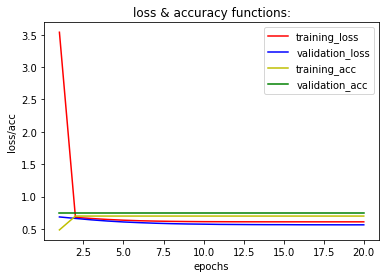

In [61]:
## plotting loss and accuracy functions for mode fourteen
loss_acc_func(model_hist, "model_fourteen")

Convolutional layer description:  conv2d_29 : (3, 3, 3, 5)
Number of filters in the convolutional layer : 5
Learned features in this layer: (R G B) channels


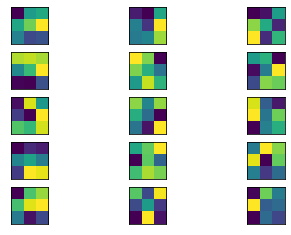

Convolutional layer description:  conv2d_30 : (3, 3, 5, 10)
Number of filters in the convolutional layer : 10
Learned features in this layer: (R G B) channels


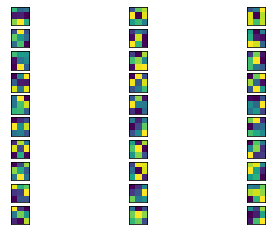

In [62]:
# displaying filters learned by model fourteen
display_filters(model_fourteen)
model_fourteen.save('model_fourteen.h5')

## **Model fifteen:**

In [63]:
#Constructing the  model fourteen
model_fifteen = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(5, (3,3), activation = 'relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(10, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# initializing optimizer
opt = tf.keras.optimizers.Adam(learning_rate = 0.00001)

# model summary
model_fifteen.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 148, 148, 5)       140       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 74, 74, 5)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 72, 72, 10)        460       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 36, 36, 10)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 12960)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 10)                129610    
_________________________________________________________________
dense_29 (Dense)             (None, 1)               

In [64]:
# train the  model fifteen
file_name = "best_val_acc_model_fifteen.h5"
model_hist = train_model(opt, loss_func, metrics_list, model_fifteen,file_name)

Epoch 1/20
13/13 [==============================] - 14s 831ms/step - loss: 0.6579 - acc: 0.6969 - val_loss: 0.6330 - val_acc: 0.7550

Epoch 00001: val_acc improved from -inf to 0.75500, saving model to best_val_acc_model_fifteen.h5
Epoch 2/20
13/13 [==============================] - 13s 897ms/step - loss: 0.6464 - acc: 0.7000 - val_loss: 0.6195 - val_acc: 0.7550

Epoch 00002: val_acc did not improve from 0.75500
Epoch 3/20
13/13 [==============================] - 15s 858ms/step - loss: 0.6376 - acc: 0.7000 - val_loss: 0.6111 - val_acc: 0.7550

Epoch 00003: val_acc did not improve from 0.75500
Epoch 4/20
13/13 [==============================] - 16s 960ms/step - loss: 0.6309 - acc: 0.7000 - val_loss: 0.6044 - val_acc: 0.7550

Epoch 00004: val_acc did not improve from 0.75500
Epoch 5/20
13/13 [==============================] - 17s 914ms/step - loss: 0.6251 - acc: 0.7000 - val_loss: 0.5973 - val_acc: 0.7550

Epoch 00005: val_acc did not improve from 0.75500
Epoch 6/20
13/13 [==============

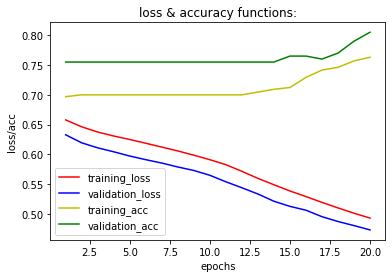

In [65]:
## plotting loss and accuracy functions for mode fifteen
loss_acc_func(model_hist, "model_fifteen")

Convolutional layer description:  conv2d_31 : (3, 3, 3, 5)
Number of filters in the convolutional layer : 5
Learned features in this layer: (R G B) channels


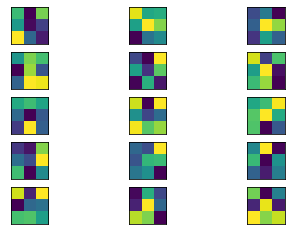

Convolutional layer description:  conv2d_32 : (3, 3, 5, 10)
Number of filters in the convolutional layer : 10
Learned features in this layer: (R G B) channels


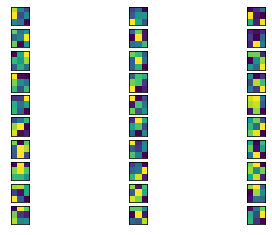

In [66]:
# displaying filters learned by model fifteen
display_filters(model_fifteen)
model_fifteen.save('model_fifteen.h5')

## **Model sixteen:**

In [67]:
#Constructing the  model sixteen
model_sixteen = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(5, (3,3), activation = 'relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(10, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# initializing optimizer
opt = tf.keras.optimizers.Adam(learning_rate = 1e-6)

# model summary
model_sixteen.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 148, 148, 5)       140       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 74, 74, 5)         0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 72, 72, 10)        460       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 36, 36, 10)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 12960)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 10)                129610    
_________________________________________________________________
dense_31 (Dense)             (None, 1)               

In [ ]:
# train the  model sixteen
file_name = "best_val_acc_model_sixteen.h5"
model_hist = train_model(opt, loss_func, metrics_list, model_sixteen, file_name)

Epoch 1/20
13/13 [==============================] - 20s 1s/step - loss: 0.7045 - acc: 0.4108 - val_loss: 0.7101 - val_acc: 0.3450

Epoch 00001: val_acc improved from -inf to 0.34500, saving model to best_val_acc_model_sixteen.h5
Epoch 2/20
13/13 [==============================] - 15s 846ms/step - loss: 0.7002 - acc: 0.4631 - val_loss: 0.7054 - val_acc: 0.3950

Epoch 00002: val_acc improved from 0.34500 to 0.39500, saving model to best_val_acc_model_sixteen.h5
Epoch 3/20
13/13 [==============================] - 15s 820ms/step - loss: 0.6964 - acc: 0.4985 - val_loss: 0.7010 - val_acc: 0.4650

Epoch 00003: val_acc improved from 0.39500 to 0.46500, saving model to best_val_acc_model_sixteen.h5
Epoch 4/20
13/13 [==============================] - 18s 983ms/step - loss: 0.6929 - acc: 0.5415 - val_loss: 0.6972 - val_acc: 0.4950

Epoch 00004: val_acc improved from 0.46500 to 0.49500, saving model to best_val_acc_model_sixteen.h5
Epoch 5/20
13/13 [==============================] - 16s 940ms/step

In [ ]:
## plotting loss and accuracy functions for mode sixteen
loss_acc_func(model_hist, "model_sixteen")

In [ ]:
# displaying filters learned by model sixteen
display_filters(model_sixteen)